In [1]:
import numpy as np 
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [2]:
#uncomment the line below if using a CUDA device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#uncomment the line below if using MAC device with MPS support
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training on:",device)

Training on: mps


In [21]:
images = []
labels = []

for folder in os.listdir("./data"):
    if folder=="dragonfly":
        for filename in os.listdir(os.path.join("./data", folder)):
            images.append(os.path.join("./data", folder, filename))
            labels.append("dragonfly")
    if folder=="grasshoppers":
        for filename in os.listdir(os.path.join("./data", folder)):
            images.append(os.path.join("./data", folder, filename))
            labels.append("grasshoppers")
    if folder=="prayingMantes":
        for filename in os.listdir(os.path.join("./data", folder)):
            images.append(os.path.join("./data", folder, filename))
            labels.append("prayingMantes")

print("Total images:",len(images))

Total images: 1300


In [22]:
data = {'ImagePath':images, 'Labels':labels} 
data = pd.DataFrame(data)
data = data.sample(frac=1).reset_index(drop=True)
lb = LabelEncoder()
data['EncodedLabels'] = lb.fit_transform(data['Labels'])

In [23]:
data.head()

,ImagePath,Labels,EncodedLabels
0,./data/prayingMantes/image313.jpg,prayingMantes,2
1,./data/dragonfly/image303.jpg,dragonfly,0
2,./data/prayingMantes/image79.jpg,prayingMantes,2
3,./data/dragonfly/image15.jpg,dragonfly,0
4,./data/prayingMantes/image29.jpg,prayingMantes,2


In [24]:
dataTrain = data[0:int(0.9*len(data))]
dataTrain = dataTrain.sample(frac=1).reset_index(drop=True)
dataTest = data[int(0.9*len(data)):]
dataTest = dataTest.sample(frac=1).reset_index(drop=True)
print("Size of training set:",len(dataTrain))
print("Size of testing set:",len(dataTest))

Size of training set: 1170
Size of testing set: 130


In [25]:
class InsectDataset(Dataset):
    def __init__(self, pathToImages, labels, transform=None):
        self.pathToImages = pathToImages
        self.transform = transform
        self.labels = labels
        
    def __len__(self):
        return len(self.pathToImages)
    
    def __getitem__(self, index):
        image = Image.open(self.pathToImages[index])
        #converts images to rgb
        image = image.convert('RGB')
        #resizing image to 256x256
        image = image.resize((256,256))
        label = torch.tensor(self.labels[index])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

datasetTrain = InsectDataset(dataTrain['ImagePath'], dataTrain['EncodedLabels'], transform)
datasetTest = InsectDataset(dataTest['ImagePath'], dataTest['EncodedLabels'], transform)

trainLoader = torch.utils.data.DataLoader(datasetTrain, batch_size=2)
testLoader = torch.utils.data.DataLoader(datasetTest, batch_size=2)

In [27]:
def displayImage(image):
    image = image / 2 + 0.5
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    return image

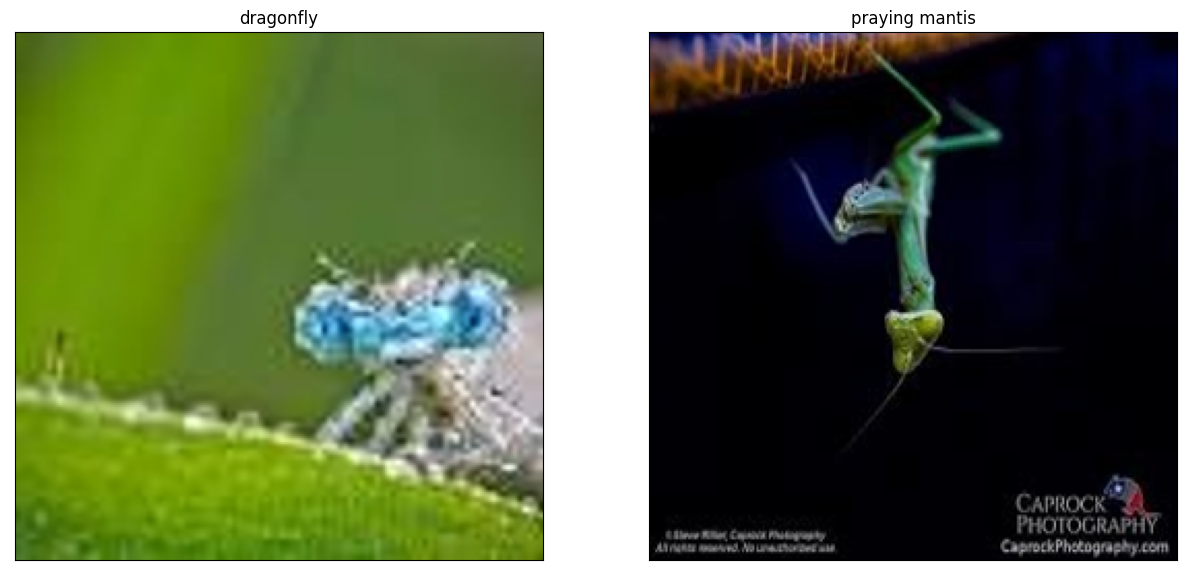

In [28]:
dataiter = iter(testLoader)
images, labels = dataiter.next()
insectType = {0: 'dragonfly', 1: 'grasshopper', 2: 'praying mantis'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 2, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(displayImage(image)) # add image
        ax.set(title = f"{insectType[label.item()]}")
        ax.set_xticks([])
        ax.set_yticks([])

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d((2,2)))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d((2,2)))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d((2,2)))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Flatten())
        self.fc1 = nn.Linear(200704, 512)
        self.fc2 = nn.Linear(512, 256)
        self.classification = nn.Linear(256, 3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.classification(x)
        x = F.log_softmax(x,dim = 1)
        return x

In [30]:
model = Net()
model.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [31]:
def evaluateModel(model):
    totalT=0
    correctT=0
    model.eval()
    with torch.no_grad():
        for dataT, targetT in (testLoader):
            dataT, targetT = dataT.to(device), targetT.to(device)
            outputT = model(dataT)
            _, predictionT = torch.max(outputT, dim=1)
            correctT += torch.sum(predictionT==targetT).item()
            totalT += targetT.size(0)
        valiationAccuracy = 100 * (correctT / totalT)
    return valiationAccuracy

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [34]:
numberOfEpochs = 1
summaryInterval = 100
validationAccuracyMax = 0.0
totalSteps = len(trainLoader)
for epoch in range(1, numberOfEpochs+1):
    print(f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(trainLoader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        if(batch_idx)%summaryInterval==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch, numberOfEpochs, batch_idx, totalSteps, loss.item()))
    validationAccuracy = evaluateModel(model)
    print("Completed training for first epoch")
    print("Accuracy on validation set:", validationAccuracy)
    if validationAccuracyMax<=validationAccuracy:
        validationAccuracyMax = validationAccuracy
        torch.save(model.state_dict(), 'classificationModel.pt')
        print('Detected network improvement, saving current model')
    model.train()

Epoch 1
Epoch [1/1], Step [0/585], Loss: 0.1815
Epoch [1/1], Step [100/585], Loss: 1.3128
Epoch [1/1], Step [200/585], Loss: 0.0076
Epoch [1/1], Step [300/585], Loss: 0.2202
Epoch [1/1], Step [400/585], Loss: 1.6192
Epoch [1/1], Step [500/585], Loss: 0.2209
Completed training for first epoch
Accuracy on validation set: 50.76923076923077
Detected network improvement, saving current model
